In [1]:
import os
import numpy as np
import pandas as pd
from collections import deque

from music21 import converter, instrument, note, chord, bar, midi, stream, meter

from keras.models import Model, Sequential
from keras.layers import *
from keras.models import load_model
import keras.backend as K
import keras.callbacks
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.
c:\users\rock_\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\rock_\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\rock_\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
midi_directory = "midi/piano_20"
# specify the number of track in each song (should be the same, in same order, for each song)
tracks = (0,)
instru = instrument.Piano()

In [4]:
notes = [[] for track in tracks]
durations = [[] for track in tracks]
offsets = [[] for track in tracks]
velocities = [[] for track in tracks]
for i, file in enumerate(os.listdir(midi_directory)):
    midi_part = converter.parse(os.path.join(midi_directory, file))
    # Parse the midi file by the notes/chords it contains
    for track, _ in enumerate(tracks):
        notes_to_parse = midi_part[tracks[track]].flat.notesAndRests
        last_offset = 0
        for elem in notes_to_parse:
            if isinstance(elem, note.Note):
                notes[track].append([str(elem.pitch)])
                durations[track].append(elem.quarterLength)
                offsets[track].append(elem.offset - last_offset)
                velocities[track].append(elem.volume.velocity)
            elif isinstance(elem, chord.Chord):
                notes[track].append([str(n.nameWithOctave) for n in elem.pitches])
                durations[track].append(elem.quarterLength)
                offsets[track].append(elem.offset - last_offset)
                velocities[track].append(elem.volume.velocity)
            elif isinstance(elem, note.Rest):
                notes[track].append([elem.name])
                durations[track].append(elem.quarterLength)
                offsets[track].append(elem.offset - last_offset)
                velocities[track].append(0)
            last_offset = elem.offset
    print("Song %s Loaded" % file)
print("DONE LOADING SONGS") 
# Get all notes
np_notes = [np.array(notes[track]) for track, _ in enumerate(tracks)]
#np_notes = [np_notes[track].flatten() for track in tracks]
notes_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for item in np_notes[track]:
        if len(item) > 1 and item != "rest":
            notes_vocab[track].append(",".join([note for note in item]))
        else:
            notes_vocab[track].append(item[0])
    notes_vocab[track] = sorted(set(notes_vocab[track]))
# Get all durations
durations_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    durations_vocab[track] = sorted(set(durations[track]))
# Get all offsets
offsets_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    offsets_vocab[track] = sorted(set(offsets[track]))
# Get all velocities
velocities_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    velocities_vocab[track] = sorted(set(velocities[track]))
    
for track, _ in enumerate(tracks):
    print("%s Notes, notes_Vocab : %s ; durations_Vocab : %s ; offsets_vocab : %s ; velocities_vocab : %s" % 
          (len(notes[track]), len(notes_vocab[track]), len(durations_vocab[track]), len(offsets_vocab[track]), len(velocities_vocab[track])))
print(notes_vocab, notes)
print(durations_vocab, durations)
print(offsets_vocab, offsets)
print(velocities_vocab, velocities)

Song alb_esp2_format0.mid Loaded
Song bach_846_format0.mid Loaded
Song beethoven_opus22_1_format0.mid Loaded
Song bk_xmas4_format0.mid Loaded
Song bor_ps6_format0.mid Loaded
Song br_rhap_format0.mid Loaded
Song burg_gewitter_format0.mid Loaded
Song chp_op31_format0.mid Loaded
Song deb_menu_format0.mid Loaded
Song god_alb_esp2_format0.mid Loaded
Song gra_esp_4_format0.mid Loaded
Song islamei_format0.mid Loaded
Song mendel_op62_4_format0.mid Loaded
Song muss_4_format0.mid Loaded
Song schuim-1_format0.mid Loaded
Song schumm-5_format0.mid Loaded
Song schu_143_1_format0.mid Loaded
Song scn15_13_format0.mid Loaded
Song ty_dezember_format0.mid Loaded
Song waldstein_3_format0.mid Loaded
DONE LOADING SONGS
33154 Notes, notes_Vocab : 4472 ; durations_Vocab : 156 ; offsets_vocab : 65 ; velocities_vocab : 100
[['A1', 'A1,A2', 'A1,C#2,A2', 'A1,C2,F2,A2', 'A1,C2,F2,F1', 'A1,D2,A2', 'A2', 'A2,A1', 'A2,A3', 'A2,A3,A1', 'A2,B-2,B-3', 'A2,C#3,E3', 'A2,C3', 'A2,C3,E3', 'A2,C3,F3', 'A2,C3,F3,F2', 'A2,D2',

In [5]:
# Save vocab to file

In [7]:
np.save("vocab_save/Piano_50.npy", np.array([notes_vocab, durations_vocab, offsets_vocab, velocities_vocab]))

In [8]:
# turn notes to integers:

In [6]:
cat_notes = [[] for track in tracks]
cat_durations = [[] for track in tracks]
cat_offsets = [[] for track in tracks]
cat_velocities = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for elem in notes[track]:
        int_note = notes_vocab[track].index(",".join(elem))
        cat = np.zeros((len(notes_vocab[track])))
        cat[int_note] = 1
        cat_notes[track].append(cat)
    for elem in durations[track]:
        int_duration = durations_vocab[track].index(elem)
        cat = np.zeros((len(durations_vocab[track])))
        cat[int_duration] = 1
        cat_durations[track].append(cat)
    for elem in offsets[track]:
        int_offset = offsets_vocab[track].index(elem)
        cat = np.zeros((len(offsets_vocab[track])))
        cat[int_offset] = 1
        cat_offsets[track].append(cat)
    for elem in velocities[track]:
        int_velocity = velocities_vocab[track].index(elem)
        cat = np.zeros((len(velocities_vocab[track])))
        cat[int_velocity] = 1
        cat_velocities[track].append(cat)
# merge
x = [cat_notes, cat_durations, cat_offsets, cat_velocities]

In [7]:
print([len(x[0][i]) for i, _ in enumerate(tracks)])

[33154]


In [8]:
# Build generator

In [9]:
seq_len = 32
batch_size = 32
split = int(0.8 * len(x[0][0]))
print(split)

class dataGenerator(Sequence):
    def __init__(self, x, batch_size):
        self.batch_size = batch_size
        self.x = x
        
    def __len__(self):
        return min([len(self.x[0][i]) for i, _ in enumerate(tracks)]) // self.batch_size - 1
    
    def __getitem__(self, idx):
        X_note = [[] for track in tracks]
        X_duration = [[] for track in tracks]
        X_offset = [[] for track in tracks]
        X_velocity = [[] for track in tracks]
        
        Y_note = [[] for track in tracks]
        Y_duration = [[] for track in tracks]
        Y_offset = [[] for track in tracks]
        Y_velocity = [[] for track in tracks]
        
        res = [[], []]
        for track, _ in enumerate(tracks):
            for i in range(self.batch_size):
                
                X_note[track].append(self.x[0][track][idx*batch_size+i : idx*batch_size+i + seq_len])
                X_duration[track].append(self.x[1][track][idx*batch_size+i : idx*batch_size+i + seq_len])
                X_offset[track].append(self.x[2][track][idx*batch_size+i : idx*batch_size+i + seq_len])
                X_velocity[track].append(self.x[3][track][idx*batch_size+i : idx*batch_size+i + seq_len])
                
                Y_note[track].append(self.x[0][track][idx*batch_size+i + seq_len])
                Y_duration[track].append(self.x[1][track][idx*batch_size+i + seq_len])
                Y_offset[track].append(self.x[2][track][idx*batch_size+i + seq_len])
                Y_velocity[track].append(self.x[3][track][idx*batch_size+i + seq_len])
            
            X_note[track] = np.array(X_note[track])
            X_duration[track] = np.array(X_duration[track])
            X_offset[track] = np.array(X_offset[track])
            X_velocity[track] = np.array(X_velocity[track])
            
            Y_note[track] = np.array(Y_note[track])
            Y_duration[track] = np.array(Y_duration[track])
            Y_offset[track] = np.array(Y_offset[track])
            Y_velocity[track] = np.array(Y_velocity[track])
            
            res[0].append(X_note[track])
            res[0].append(X_duration[track])
            res[0].append(X_offset[track])
            res[0].append(X_velocity[track])
            
            res[1].append(Y_note[track])
            res[1].append(Y_duration[track])
            res[1].append(Y_offset[track])
            res[1].append(Y_velocity[track])
            
        return res
    
data_gen = dataGenerator(x, batch_size)
#val_gen = dataGenerator(np.array(x)[:, :, split:], batch_size)

26523


In [10]:
print(data_gen[0][0][0].shape)
#print(val_gen[0][0][0].shape)

(32, 32, 4472)


In [11]:
# Build Model

In [13]:
K.clear_session()

inputs_list = []
tracks_list = []
outputs_list = []

for track, _ in enumerate(tracks):
    in_note = Input(shape=(seq_len, len(notes_vocab[track])))
    inputs_list.append(in_note)
    #x1 = CuDNNLSTM(128, return_sequences=True)(in_note)
    #x1 = Bidirectional(CuDNNLSTM(64))(x1)
    x1 = LSTM(128, return_sequences=True)(in_note)
    x1 = Bidirectional(LSTM(64))(x1)
    x1 = Dropout(0.3)(x1)
    tracks_list.append(x1)
    
    in_duration = Input(shape=(seq_len, len(durations_vocab[track])))
    inputs_list.append(in_duration)
    #x2 = CuDNNLSTM(128, return_sequences=True)(in_duration)
    #x2 = Bidirectional(CuDNNLSTM(64))(x2)
    x2 = LSTM(128, return_sequences=True)(in_duration)
    x2 = Bidirectional(LSTM(64))(x2)
    x2 = Dropout(0.3)(x2)
    tracks_list.append(x2)

    in_offset = Input(shape=(seq_len, len(offsets_vocab[track])))
    inputs_list.append(in_offset)
    #x3 = CuDNNLSTM(128, return_sequences=True)(in_offset)
    #x3 = Bidirectional(CuDNNLSTM(64))(x3)
    x3 = LSTM(128, return_sequences=True)(in_offset)
    x3 = Bidirectional(LSTM(64))(x3)
    x3 = Dropout(0.3)(x3)
    tracks_list.append(x3)
    
    in_velocity = Input(shape=(seq_len, len(velocities_vocab[track])))
    inputs_list.append(in_velocity)
    #x4 = CuDNNLSTM(128, return_sequences=True)(in_velocity)
    #x4 = Bidirectional(CuDNNLSTM(64))(x4)
    x4 = LSTM(128, return_sequences=True)(in_velocity)
    x4 = Bidirectional(LSTM(64))(x4)
    x4 = Dropout(0.3)(x4)
    tracks_list.append(x4)

concat = Concatenate()(tracks_list)
shared = Dense(512, activation='relu')(concat)
shared = Dense(256, activation='relu')(shared)

for track, _ in enumerate(tracks):
    out_note = Dense(len(notes_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_note)
    
    out_duration = Dense(len(durations_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_duration)
    
    out_offset = Dense(len(offsets_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_offset)
    
    out_velocity = Dense(len(velocities_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_velocity)

model = Model(inputs=inputs_list, 
              outputs=outputs_list)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 4472)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 156)      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 32, 65)       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 32, 100)      0                                            
____________________________________________________________________________________________

In [14]:
#save best model if model improved
model_name = "Piano_20.h5"
best_checkpoint = keras.callbacks.ModelCheckpoint(os.path.join("weight_save", model_name), monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [20]:
h = model.fit_generator(data_gen, epochs = 20, callbacks=[])

Epoch 1/20
1035/1035 [==============================] - 298s 288ms/step - loss: 8.4439 - dense_3_loss: 4.6435 - dense_4_loss: 0.7124 - dense_5_loss: 0.4707 - dense_6_loss: 2.6173 - dense_3_acc: 0.2508 - dense_4_acc: 0.7915 - dense_5_acc: 0.8694 - dense_6_acc: 0.2776
Epoch 2/20
1035/1035 [==============================] - 298s 287ms/step - loss: 8.3198 - dense_3_loss: 4.5782 - dense_4_loss: 0.6997 - dense_5_loss: 0.4603 - dense_6_loss: 2.5816 - dense_3_acc: 0.2579 - dense_4_acc: 0.7963 - dense_5_acc: 0.8721 - dense_6_acc: 0.2874
Epoch 3/20
1035/1035 [==============================] - 298s 288ms/step - loss: 8.1639 - dense_3_loss: 4.4476 - dense_4_loss: 0.7033 - dense_5_loss: 0.4562 - dense_6_loss: 2.5568 - dense_3_acc: 0.2614 - dense_4_acc: 0.7960 - dense_5_acc: 0.8738 - dense_6_acc: 0.2950
Epoch 4/20
1035/1035 [==============================] - 298s 288ms/step - loss: 7.9790 - dense_3_loss: 4.3262 - dense_4_loss: 0.6899 - dense_5_loss: 0.4452 - dense_6_loss: 2.5177 - dense_3_acc: 0.271

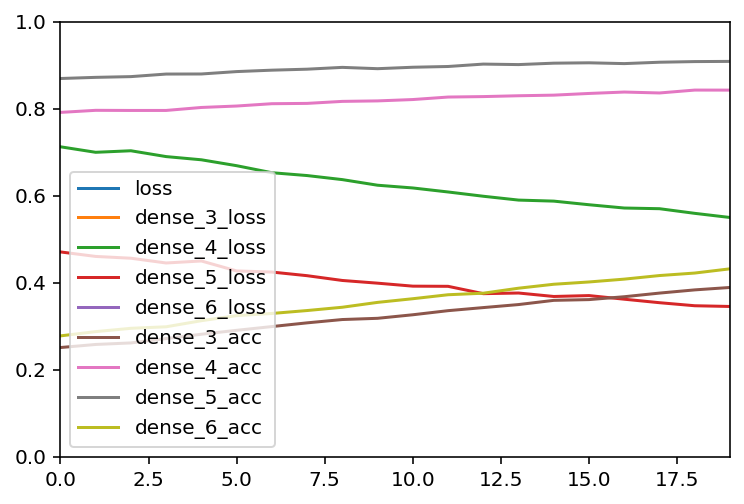

In [21]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [22]:
# Load / save

In [34]:
model.save(os.path.join("weight_save", model_name))
#model = load_model(os.path.join("weight_save", model_name))

In [13]:
# Test

In [29]:
# Build seed
idx = 402 #+ seq_len
x_test, _ = data_gen[idx]
x_test = [x_test[i][0] for i in range(len(x_test))]
x_test_stream = [stream.Stream() for track in tracks]

for track, _ in enumerate(tracks):
    for i in range(len(x_test[0])):
        str_note = notes_vocab[track][np.argmax(x_test[4*track][i])]
        _duration = durations_vocab[track][np.argmax(x_test[4*track+1][i])]
        _offset = offsets_vocab[track][np.argmax(x_test[4*track+2][i])]
        _velocity = velocities_vocab[track][np.argmax(x_test[4*track+3][i])]
        if len(str_note.split(",")) > 1:
            _chord = chord.Chord(str_note.split(","))
            _chord.quarterLength = _duration
            _chord.offset = _offset
            _chord.volume.velocity = _velocity
            x_test_stream[track].append(_chord)
        else:
            if str_note != "rest":
                _note = note.Note(str_note)
                _note.quarterLength = _duration
                _note.offset = _offset
                _note.volume.velocity = _velocity
                x_test_stream[track].append(_note)
            else:
                _rest = note.Rest()
                _rest.quarterLength = _duration
                _rest.offset = _offset
                x_test_stream[track].append(_rest)
    x_test_stream[track].insert(0, instru)

In [30]:
# make seq_len predictions from seed
preds = [[] for track in tracks]
x = x_test

for _ in range(4 * seq_len):
    pred = model.predict([np.array([x[i]]) for i in range(len(x))])
    _note = [pred[i] for i in range(0, len(pred), 4)]
    _duration = [pred[i] for i in range(1, len(pred), 4)]
    _offset = [pred[i] for i in range(2, len(pred), 4)]
    _velocity = [pred[i] for i in range(3, len(pred), 4)]
    for track, _ in enumerate(tracks):
        cat_note = np.zeros((len(notes_vocab[track])))
        _note[track] = np.argmax(_note[track])
        cat_note[_note[track]] = 1
        cat_duration = np.zeros((len(durations_vocab[track])))
        _duration[track] = np.argmax(_duration[track])
        cat_duration[_duration[track]] = 1
        cat_offset = np.zeros((len(offsets_vocab[track])))
        _offset[track] = np.argmax(_offset[track])
        cat_offset[_offset[track]] = 1
        cat_velocity = np.zeros((len(velocities_vocab[track])))
        _velocity[track] = np.argmax(_velocity[track])
        cat_velocity[_velocity[track]] = 1
        
        x[4*track] = x[4*track][1:]
        x[4*track] = list(x[4*track]) + [cat_note]
        
        x[4*track+1] = x[4*track+1][1:]
        x[4*track+1] = list(x[4*track+1]) + [cat_duration]
        
        x[4*track+2] = x[4*track+2][1:]
        x[4*track+2] = list(x[4*track+2]) + [cat_offset]
        
        x[4*track+3] = x[4*track+3][1:]
        x[4*track+3] = list(x[4*track+3]) + [cat_velocity]
        
        preds[track].append((cat_note, cat_duration, cat_offset, cat_velocity))

In [31]:
# Build predicted stream
y_test_stream = [stream.Stream() for track in tracks]

for track, _ in enumerate(tracks):
    for i in range(len(preds[track])):
        str_note = notes_vocab[track][np.argmax(preds[track][i][0])]
        _duration = durations_vocab[track][np.argmax(preds[track][i][1])]
        _offset = offsets_vocab[track][np.argmax(preds[track][i][2])]
        _velocity = velocities_vocab[track][np.argmax(preds[track][i][3])]
        
        if len(str_note.split(",")) > 1:
            _chord = chord.Chord(str_note.split(","))
            _chord.quarterLength = _duration
            _chord.offset = _offset
            _chord.volume.velocity = _velocity
            y_test_stream[track].append(_chord)
        else:
            if str_note != "rest":
                _note = note.Note(str_note)
                _note.quarterLength = _duration
                _note.offset = _offset
                _note.volume.velocity = _velocity
                y_test_stream[track].append(_note)
            else:
                _rest = note.Rest()
                _rest.quarterLength = _duration
                _rest.offset = _offset
                y_test_stream[track].append(_rest)
    y_test_stream[track].insert(0, instru)

In [32]:
# play seed
x_full_score = stream.Score()
for track, _ in enumerate(tracks):
    p = stream.Part()
    p.append(x_test_stream[track])
    x_full_score.insert(0, p)
x_full_score.write("midi", "x_test.mid")
sp = midi.realtime.StreamPlayer(x_full_score)
sp.play()

In [33]:
# play generated music
y_full_score = stream.Score()
for track, _ in enumerate(tracks):
    p = stream.Part()
    p.append(y_test_stream[track])
    y_full_score.insert(0, p)
y_full_score.write("midi", "y_test.mid")
sp = midi.realtime.StreamPlayer(y_full_score)
sp.play()

KeyboardInterrupt: 